In [2]:
%load_ext autotime

time: 361 µs (started: 2022-06-28 12:26:18 +08:00)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

time: 774 ms (started: 2022-06-28 12:26:18 +08:00)


In [4]:
from matplotlib.backends.backend_pdf import PdfPages

time: 60.5 ms (started: 2022-06-28 12:26:19 +08:00)


In [5]:
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

time: 294 µs (started: 2022-06-28 12:26:19 +08:00)


In [6]:
all_rows = pd.option_context("display.max_rows", None)

time: 153 µs (started: 2022-06-28 12:26:19 +08:00)


In [7]:
months = pd.Series({m: i for i, m in enumerate("FGHJKMNQUVXZ")})

time: 765 µs (started: 2022-06-28 12:26:19 +08:00)


In [8]:
dailies = pd.read_parquet("csi_data.parquet")

# Adjust for multiplier inconsistencies in old data
for contract, mult in [
    ("SXE", 1/10), ("SXX", 1/10), 
    ("CU", 10), ("JY", 10), ("CD", 10),
]:
    dailies.loc[
        (dailies.contract == contract) & 
        (dailies.date < "2008"), 
        "close",
    ] *= mult

time: 18.6 s (started: 2022-06-28 12:26:19 +08:00)


In [9]:
prev_close = dailies.sort_values("date").groupby(["contract", "expiry"]).close.shift()
dailies["d_close"] = dailies["close"] - prev_close

time: 27 s (started: 2022-06-28 12:26:38 +08:00)


In [10]:
dailies["expiry_int"] = (
    dailies["expiry"].str.slice(0, 4).astype(int) * 12 + 
    dailies["expiry"].str.slice(4, 5).map(months)
)

time: 28.3 s (started: 2022-06-28 12:27:05 +08:00)


In [11]:
dailies["mod_month"] = dailies.eval(
    "expiry_int - (date.dt.year + (expiry_int.mod(12) < date.dt.month.sub(1))) * 12"
)

time: 4.52 s (started: 2022-06-28 12:27:33 +08:00)


In [12]:
dailies[["expiry_int", "mod_month"]] = dailies[["expiry_int", "mod_month"]].astype("Int64")

time: 16.9 s (started: 2022-06-28 12:27:38 +08:00)


In [13]:
dailies = dailies.query("mod_month.between(0, 11)").copy()

time: 7.04 s (started: 2022-06-28 12:27:55 +08:00)


In [14]:
dailies["mod_month"] = pd.Categorical.from_codes(dailies["mod_month"], months.index)

time: 61.2 ms (started: 2022-06-28 12:28:02 +08:00)


In [15]:
metadata = (
    pd.read_csv("contracts.csv")
    .dropna(subset=["Exch Symbol", "Currency", "Name", "Point Value", 
                    "Symbol", 'Futures Category'])
    .set_index("Symbol")
)

time: 19.7 ms (started: 2022-06-28 12:28:02 +08:00)


In [16]:
names = metadata["Name"].str.lower()
point_values = metadata["Point Value"].str.lower()

time: 1.56 ms (started: 2022-06-28 12:28:02 +08:00)


In [17]:
contract_mask = (
    metadata.Currency.isin(["USD", "EUR"])
    &
    ~point_values.str.contains("contract")
    &
    ~point_values.str.contains("mwh")    
    &
    ~names.index.isin(["TF", "ER2", "ZI"])
    &
    (
        names.str.contains("combined session")
        |
        ~names.str.contains("session")
    )
    &
    ~names.str.contains("divided by 10")
    &
    ~names.str.contains("last in")
    &
    ~names.str.contains("last trade in close")  
    &
    ~names.str.contains("floor trading only")
    &
    ~names.str.contains("\(floor\)")    
)

time: 7.73 ms (started: 2022-06-28 12:28:02 +08:00)


In [18]:
multiplier = (
    point_values
    .loc[
        lambda df: (
            df.str.match("^(usd|eur|\$|\d)")
            |
            df.str.contains("us dollar")
        )
    ]
    .str.extract("(\d+(?:\.\d+)?)", expand=False).astype(float)
    .rename("multiplier")
)
metadata["multiplier"] = multiplier

time: 3.72 ms (started: 2022-06-28 12:28:02 +08:00)


In [19]:
dailies = dailies.loc[lambda df: df.contract.map(contract_mask).fillna(False)]

time: 3.92 s (started: 2022-06-28 12:28:02 +08:00)


In [20]:
contract_volumes = (
    dailies
    .assign(decade=lambda df: df.eval("date.dt.year.floordiv(10).mul(10)"))
    .assign(adr=lambda df: df.eval("high - low"))
    .groupby(["contract", "decade"])
    .agg({"volume": "mean", "adr": "mean"})
    .reset_index()
)

time: 1.86 s (started: 2022-06-28 12:28:06 +08:00)


In [21]:
contract_volumes["multiplier"] = contract_volumes.contract.map(metadata.multiplier)
contract_volumes["currency"] = contract_volumes.contract.map(metadata.Currency)
contract_volumes["category"] = contract_volumes.contract.map(metadata['Futures Category'])
contract_volumes["exchange"] = contract_volumes.contract.map(metadata.Exchange)
contract_volumes["exch_symbol"] = contract_volumes.contract.map(metadata['Exch Symbol'])
contract_volumes["name"] = contract_volumes.contract.map(metadata['Name'])
contract_volumes["dollar_vol"] = contract_volumes.eval("adr * multiplier * volume")
contract_volumes["cat_rank"] = (
    contract_volumes.groupby(["category", "decade"])
    .dollar_vol.rank(ascending=False)
    .astype(int)
)
contract_volumes["start_year"] = contract_volumes.contract.map(
    dailies.groupby("contract").date.min().dt.year.astype("Int64")
)

time: 342 ms (started: 2022-06-28 12:28:08 +08:00)


In [74]:
shortlist = (
    contract_volumes    
    .query("cat_rank <= 6 & start_year < 2000 & decade == 2010")
    .query("dollar_vol.rank(ascending=False) <= 50")
    .sort_values("dollar_vol", ascending=False)
    [["dollar_vol", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .reset_index(drop=True)
)
with pd.option_context("display.max_rows", None):
    display(
        shortlist
        .style
        .format(subset=["dollar_vol"], formatter="{:.1e}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
0,4.2e+08,USD,ES,CME,ES,Indexes-U.S.,1,e-mini S&P 500 Index-CME,1982
1,3.2e+08,USD,US,CBT,ZB,Govt Bonds,1,U.S. T-Bond (Floor+Electronic Combined)-CBT,1977
2,1.8e+08,USD,TY,CBT,TYF,Govt Notes,1,10-Year U.S. T-Note (Floor+Electronic Combined)-CBT,1982
3,1.7e+08,EUR,SXE,EUREX,FESX,Indexes-European,1,Euro STOXX 50 Index-EUREX,1998
4,1.2e+08,EUR,FDX,EUREX,FDAX,Indexes-European,2,DAX Index-EUREX,1990
5,1.2e+08,EUR,EBL,EUREX,FGBL,Govt Bonds,2,Euro German Bund-EUREX,1990
6,1.1e+08,USD,CL2,NYMEX,YC,Energy,1,Crude Oil (Floor+Electronic Combined)-NYMEX,1983
7,9.8e+07,USD,FV,CBT,FV,Govt Notes,2,5-Year U.S. T-Note (Floor+Electronic Combined)-CBT,1988
8,9.0e+07,USD,LCO,ICE,B,Energy,2,Brent Crude (Combined)-(IPE),1988
9,6.5e+07,USD,CU,CME,Y2,FOREX,1,Euro (Floor+Electronic Combined)-CME,1976


time: 27.4 ms (started: 2022-06-28 12:44:12 +08:00)


In [75]:
top_ratio = (
    dailies
    .query("date > '2008'")
    .sort_values("volume")
    .groupby(["contract", "date"]).last()
    .groupby(["contract", "mod_month"]).volume.count()
)
top_ratio /= top_ratio.groupby("contract").transform("max")

time: 24.8 s (started: 2022-06-28 12:44:19 +08:00)


In [76]:
with PdfPages('expiry_volumes.pdf') as pdf:
    for contract_rank in tqdm(shortlist.index):

        title = "{contract_rank} - {contract} / {exch_symbol}({exchange}) / {name}".format(
            contract_rank=contract_rank, **shortlist.loc[contract_rank].to_dict()
        )

        plt.figure(dpi=100)

        ax = (
            top_ratio
            .loc[shortlist.contract[contract_rank]]
            .plot.bar(figsize=(8, 5), title=title)
        )
        
        ax.axhline(y=1/12, color="red")
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 2.08 s (started: 2022-06-28 12:44:44 +08:00)


In [77]:
active_months = top_ratio[top_ratio > 1/12].reset_index().drop("volume", axis=1)
dailies = dailies.merge(active_months)

time: 1.12 s (started: 2022-06-28 12:44:46 +08:00)


In [78]:
volumes = dailies.set_index(["contract", "date", "expiry"]).volume.loc[lambda xs: xs > 0]
volumes /= volumes.groupby(["contract", "date"]).transform("sum")
volumes = volumes.sort_index().rename("volume_fraction")
volumes = volumes.groupby(["contract", "expiry"]).shift()

time: 2.2 s (started: 2022-06-28 12:44:47 +08:00)


In [79]:
live_contracts = (
    volumes
    .loc[lambda df: df.groupby(["contract", "expiry"]).cummax().gt(1/3)]
    .reset_index()
)

time: 286 ms (started: 2022-06-28 12:44:49 +08:00)


In [80]:
live_contracts = live_contracts.merge(dailies, how="left")

time: 2.4 s (started: 2022-06-28 12:44:49 +08:00)


In [81]:
front = (
    live_contracts
    .sort_values("expiry")
    .groupby(["contract", "date"]).first()
)

time: 28.4 s (started: 2022-06-28 12:44:52 +08:00)


In [82]:
front["vol"] = (
    front
    .d_close.abs()
    .groupby("contract").rolling(180).mean()
    .reset_index(level=0, drop=True)
    .groupby("contract").shift()
)

time: 188 ms (started: 2022-06-28 12:45:20 +08:00)


In [83]:
with PdfPages('prices.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            front.loc[contract.contract]
            .eval("d_close / vol").cumsum()
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 3.19 s (started: 2022-06-28 12:45:20 +08:00)


In [84]:
ndays = 90
signal = (
    front
    .eval("d_close / vol")
    .groupby("contract").cumsum()
    .pipe(lambda xs: (
        xs.groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
        .lt(xs)
    ))
    .groupby("contract").shift(fill_value=False)
    .groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
)

time: 351 ms (started: 2022-06-28 12:50:17 +08:00)


In [85]:
with PdfPages('signals.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            signal.loc[contract.contract]
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/50 [00:00<?, ?it/s]

time: 2.68 s (started: 2022-06-28 12:50:18 +08:00)


In [86]:
rets = front.eval("d_close / vol * @signal")
start_year = "1980"

time: 90.9 ms (started: 2022-06-28 12:50:20 +08:00)


In [87]:
pnl = rets.loc[shortlist.contract].groupby("date").sum()[start_year:]

time: 110 ms (started: 2022-06-28 12:50:20 +08:00)


In [88]:
with PdfPages('returns.pdf') as pdf:
    
    c_pl = pnl.cumsum()
    plt.figure(figsize=(8, 5), dpi=100)
    c_pl.plot(lw=1, color="black", title="Portfolio")
    plt.fill_between(c_pl.index, c_pl, c_pl.cummax(), facecolor='red', alpha=0.5);
    pdf.savefig()
    plt.close()
    
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            rets.loc[contract.contract]
            .cumsum().plot(figsize=(8, 5), title=title, xlim=(pnl.index[0], pnl.index[-1]))
        )
        
        pdf.savefig()
        plt.close()

  0%|          | 0/50 [00:00<?, ?it/s]

time: 3.25 s (started: 2022-06-28 12:50:21 +08:00)


In [89]:
decade = (pnl.index.get_level_values("date").year // 10) * 10

time: 1.16 ms (started: 2022-06-28 12:50:25 +08:00)


In [90]:
by_period = {}
legend = []
for _, pnl0 in pnl.groupby(decade):
    yr0 = pnl0.index.year[0]
    pnl0.index = ((pnl0.index - pd.Timestamp(yr0, 1, 1)) / pd.Timedelta(days=1)).astype(int)
    by_period[yr0] = pnl0
by_period = pd.DataFrame(by_period)

time: 4.15 ms (started: 2022-06-28 12:50:25 +08:00)


<AxesSubplot:xlabel='date'>

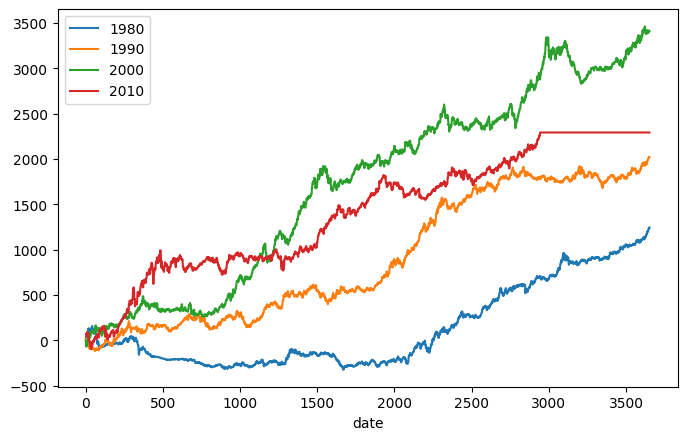

time: 103 ms (started: 2022-06-28 12:50:25 +08:00)


In [91]:
plt.figure(figsize=(8, 5), dpi=100)
by_period.cumsum().fillna(method="ffill").plot(ax=plt.gca())

In [92]:
by_period.apply(lambda xs: xs.mean() / xs.std() * 250**0.5)

1980    0.867637
1990    1.137236
2000    1.334155
2010    1.150449
dtype: float64

time: 11.2 ms (started: 2022-06-28 12:50:27 +08:00)
